In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

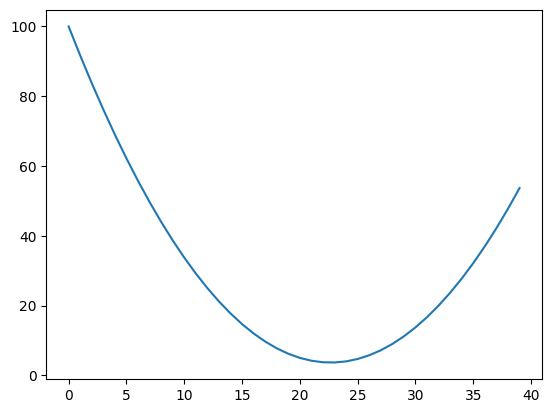

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(ys)
plt.show()

In [5]:
h = 0.00001
x = 2/3
(f(x+h)-f(x))/h

3.0000002482211127e-05

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [39]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __rsub__(self, other): # self - other
    return -other + self

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [40]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot  

In [41]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

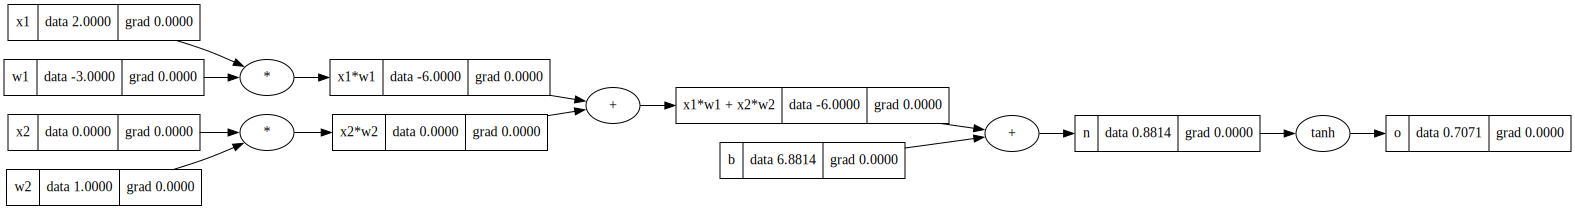

In [42]:
draw_dot(o)

In [43]:
o.backward()

In [44]:
import random

In [53]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        out = [n(x) for n in self.neurons ]
        return out[0] if len(out) == 1 else out
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x 
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [54]:
x = [2.0, 3.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.9842344207155228)

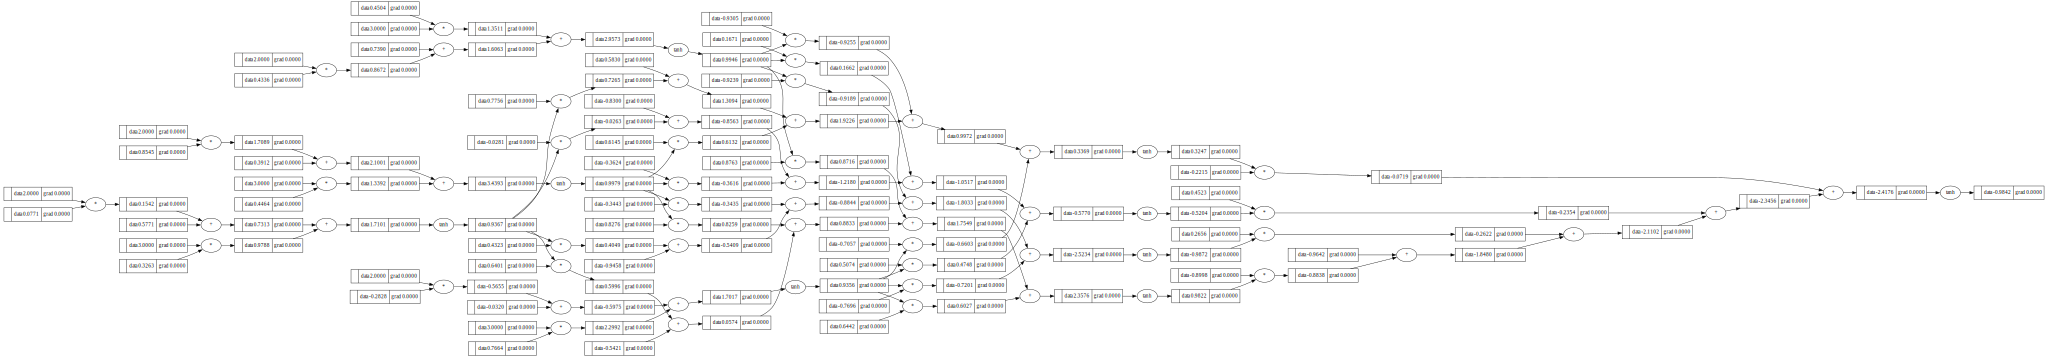

In [55]:
draw_dot(n(x))

In [56]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

[Value(data=-0.984024358756292),
 Value(data=-0.9798083691040331),
 Value(data=-0.9837142838761945),
 Value(data=-0.9853418467322916)]

In [116]:
n = MLP(3, [4,4,1])

for k in range(20):

    ypred = [n(x) for x in xs]
    loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])

    for p in n.parameters():
        p.grad = 0

    loss.backward()

    for p in n.parameters():
        p.data += -.05 * p.grad

    print(k, loss.data)

0 3.3311102484033612
1 1.1452430592514449
2 0.5695334356408052
3 0.33730285147128525
4 0.2420748553913606
5 0.186314524238891
6 0.15027095004631869
7 0.125282805302393
8 0.10704369653068312
9 0.09319843473630333
10 0.08236042252885636
11 0.07366432718954927
12 0.0665441086875252
13 0.06061489616047471
14 0.05560640071242491
15 0.051323527537985004
16 0.047622106437392724
17 0.044393405082195456
18 0.041553942344305705
19 0.03903860769815734
